In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import warnings                      #To tweak warning options
import datetime as dt                #For date objects and implemetations
from graphviz import Source               #For storing decision tree visualizations
import joblib                        #For saving objects, more efficient at serializing large numpy arrays than pickle module

import xgboost                       #For training an extreme gradient boosting model on data
import sklearn
from sklearn.base import BaseEstimator               #For creating a simple baseline model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures  #For standardizing/tranforming numeric variables
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV  #For performing model cross-validation
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,\
    recall_score, f1_score, fbeta_score, precision_recall_curve, roc_curve, roc_auc_score, auc, make_scorer  #For evaluating classifier model


pd.set_option('display.max_columns', None)

In [2]:
# loading csv and choosing variables

df = pd.read_csv('../../data/census_epa_theil_cleaned.csv')
df = df = df[[
    'pct_pop_white_only',
    'pct_pop_black',
    'pct_pop_asian',
    'pct_pop_hispanic_latino_any',
    'pop_density',
    'prim_ind_share',
    'sec_ind_share',
    'poverty_pct',
    'theil_income_median',
    'health_ins_pct',
    'PM25',
    'OZONE',
    'DSLPM',
    'PTRAF',
    'PRE1960PCT',
    'PNPL',
    'PRMP',
    'PTSDF',
    'UST',
    'PWDIS'
]]

print(df.isnull().sum())

# plt.figure(figsize=(12,8))
# sns.heatmap(df.isnull(), cmap='viridis', cbar=False)

pct_pop_white_only             0
pct_pop_black                  0
pct_pop_asian                  0
pct_pop_hispanic_latino_any    0
pop_density                    0
prim_ind_share                 0
sec_ind_share                  0
poverty_pct                    0
theil_income_median            0
health_ins_pct                 0
PM25                           0
OZONE                          0
DSLPM                          0
PTRAF                          0
PRE1960PCT                     0
PNPL                           0
PRMP                           0
PTSDF                          0
UST                            0
PWDIS                          0
dtype: int64


In [3]:
# setting PM25_high as target binary variable and making urban cutoff

df['PM25_high'] = np.where(df['PM25'] > 9, 1 ,0)
df = df[df['pop_density'] > 500]

print(len(df[df['PM25_high']==1])/len(df))

0.3383888203863543


In [4]:
# separating independent and dependent variables

y = df['PM25_high']
X = df.drop(['PM25', 'PM25_high'], axis=1)
X.head()

,pct_pop_white_only,pct_pop_black,pct_pop_asian,pct_pop_hispanic_latino_any,pop_density,prim_ind_share,sec_ind_share,poverty_pct,theil_income_median,health_ins_pct,OZONE,DSLPM,PTRAF,PRE1960PCT,PNPL,PRMP,PTSDF,UST,PWDIS
1,39.054726,58.457711,2.736318,0.497512,605.272556,0.000000,6.746712,6.6,4.435235e-06,93.024585,60.02012,0.176942,65.510247,0.294511,0.072671,0.082691,0.067863,2.208384,0.097622
2,68.017892,30.891809,3.634330,0.363433,668.689248,0.000000,7.450098,17.2,1.944627e-06,96.232780,59.90393,0.204497,46.665740,0.087077,0.075500,0.082142,0.071178,1.830997,0.001432
3,89.689637,7.048922,0.920568,0.736454,595.525072,0.079051,11.646904,8.1,7.687476e-07,95.177866,59.95221,0.242509,144.572390,0.081486,0.084302,0.087589,0.079793,2.958719,0.000062
4,75.850262,22.939968,0.639123,2.168455,706.196703,0.000000,3.865074,18.0,2.502762e-06,96.439447,59.92819,0.261567,73.784886,0.005914,0.106715,0.103047,0.100418,3.004055,0.017290
5,80.318510,4.987981,12.980769,15.084135,1586.733988,0.000000,7.016960,3.6,1.707180e-06,100.000000,59.92819,0.261567,83.147044,0.027938,0.092181,0.085835,0.089865,1.111991,0.015404


In [5]:
# 75/25 train-test split with stratification and seed=42

X_train , X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print("Original high percent: " + str(y.sum()/len(y)))
print("Train high percent: " + str(y_train.sum()/len(y_train)))
print("Test high percent: " + str(y_test.sum()/len(y_test)))
print("The train/test split percent is: " + str(len(y_train)/len(y)*100) + " / " + str(len(y_test)/len(y)*100))

Original high percent: 0.3383888203863543
Train high percent: 0.33840252089327305
Test high percent: 0.338347718865598
The train/test split percent is: 75.0 / 25.0


In [6]:
# scaling the train and test data separately-- minmax scaler for everything, since our variables aren't normally distributed

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# defining the f2 metric (since there isn't one built-in, it's a common special case of fbeta metric)
# Note: this is the negative since xgboost minimizes its objective function, if your model maximizes get rid of the negative sign

def f2_eval(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)

    f2 = fbeta_score(y_true, y_pred_binary, beta=2)
    
    return 'f2_score', -f2


In [8]:
# making my model and training it
# some of these hyperparameters came from gridsearchCV (see below)

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=42, scale_pos_weight=2, learning_rate=0.3, gamma=0.25, reg_lambda=3)
xgb_clf = xgb_clf.fit(
    X_train,
    y_train,
    verbose=True,
    early_stopping_rounds=20,
    eval_metric=f2_eval,
    eval_set = [(X_test, y_test)]
)


[0]	validation_0-logloss:0.61194	validation_0-f2_score:-0.73574
[1]	validation_0-logloss:0.56671	validation_0-f2_score:-0.77208
[2]	validation_0-logloss:0.53245	validation_0-f2_score:-0.78045
[3]	validation_0-logloss:0.50644	validation_0-f2_score:-0.78293
[4]	validation_0-logloss:0.48645	validation_0-f2_score:-0.79045
[5]	validation_0-logloss:0.46946	validation_0-f2_score:-0.79440
[6]	validation_0-logloss:0.45606	validation_0-f2_score:-0.79733
[7]	validation_0-logloss:0.44241	validation_0-f2_score:-0.80025
[8]	validation_0-logloss:0.43668	validation_0-f2_score:-0.79965
[9]	validation_0-logloss:0.42873	validation_0-f2_score:-0.80354
[10]	validation_0-logloss:0.42232	validation_0-f2_score:-0.80558
[11]	validation_0-logloss:0.41898	validation_0-f2_score:-0.80594
[12]	validation_0-logloss:0.40511	validation_0-f2_score:-0.81047
[13]	validation_0-logloss:0.39624	validation_0-f2_score:-0.81402


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-logloss:0.39264	validation_0-f2_score:-0.81526
[15]	validation_0-logloss:0.39083	validation_0-f2_score:-0.81533
[16]	validation_0-logloss:0.38806	validation_0-f2_score:-0.81619
[17]	validation_0-logloss:0.38163	validation_0-f2_score:-0.81658
[18]	validation_0-logloss:0.37954	validation_0-f2_score:-0.81765
[19]	validation_0-logloss:0.37434	validation_0-f2_score:-0.81954
[20]	validation_0-logloss:0.36736	validation_0-f2_score:-0.82232
[21]	validation_0-logloss:0.36528	validation_0-f2_score:-0.82383
[22]	validation_0-logloss:0.35959	validation_0-f2_score:-0.82576
[23]	validation_0-logloss:0.35875	validation_0-f2_score:-0.82537
[24]	validation_0-logloss:0.35788	validation_0-f2_score:-0.82615
[25]	validation_0-logloss:0.35354	validation_0-f2_score:-0.82904
[26]	validation_0-logloss:0.34903	validation_0-f2_score:-0.83099
[27]	validation_0-logloss:0.34361	validation_0-f2_score:-0.83275
[28]	validation_0-logloss:0.34220	validation_0-f2_score:-0.83200
[29]	validation_0-logloss

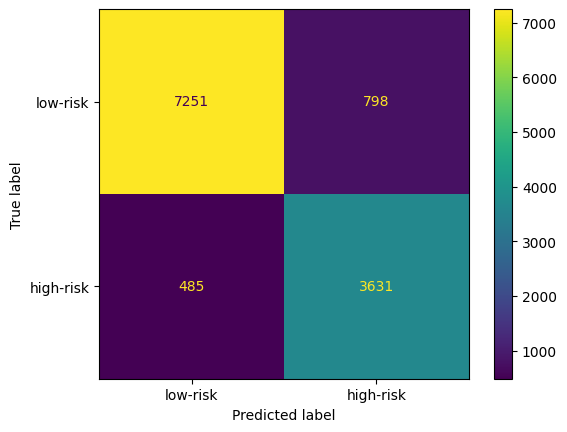

In [9]:
# making the confusion matrix on the test data

y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


precision: 0.8198238880108376 | baseline: 0.338347718865598
recall: 0.8821671525753159 | baseline: 1
f1 score: 0.8498537156231714 | baseline: 0.5056200479086052
f2 score: 0.8689513234097545 | baseline: 0.7188515141988892
AUC-PR: 0.9347688413779147 | baseline: 0.338347718865598


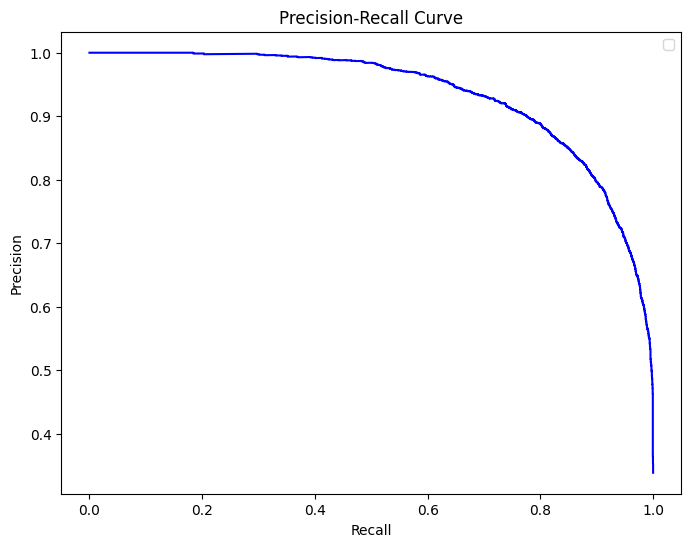

In [11]:
# evaluating all the metrics we want on the test data

y_prob = xgb_clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)

high_pct = y_test.sum()/len(y_test)

print("precision: " + str(precision_score(y_test, y_pred)) + " | baseline: " + str(high_pct))
print("recall: " + str(recall_score(y_test, y_pred)) + " | baseline: " + str(1))
print("f1 score: " + str(fbeta_score(y_test, y_pred, beta=1)) + " | baseline: " + str(2*high_pct/(high_pct+1)))
print("f2 score: " + str(fbeta_score(y_test, y_pred, beta=2)) + " | baseline: " + str(5*high_pct/(4*high_pct+1)))
print("AUC-PR: " + str(auc(recall, precision)) + " | baseline: " + str(high_pct))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [13]:
# setting up gridsearchCV to help tune hyperparameters
# Note: this may take a long time depending on your hyperparameters! i did it in a bunch of runs with different param_grids, this is just the final one
# this run was short (cause only 45 fits) but another one took 20 minutes!

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'gamma': [0,0.25, 0.5],
    'reg_lambda': [0, 3, 10]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.25,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.3, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=-999, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'gamma': [0, 0.25, 0.5], 'reg_lambda': [0, 3, 10]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [15]:
# printing the best hyperparameters and f2 from gridsearchCV
print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

# evaluating the best gridsearchCV model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
f2_score_test = fbeta_score(y_test, y_pred, beta=2)
print("f2 on test: ", f2_score_test)

Best Hyperparameters: {'gamma': 0.25, 'reg_lambda': 3}
Best f2:  0.867472154411152
f2 on test:  0.8689513234097545
